# Preprocessing the training and test data

In [3]:
"""using this guide: https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
other links to check:
- https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
"""

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

#train and test data directory
train_data_dir = "../data/duke2D_for_CNN/train"
test_data_dir = "../data/duke2D_for_CNN/test"

#TODO: test model on the other datasets (OCTID)
#load the train and test data
"""TODO: deal with the size pb (https://stats.stackexchange.com/questions/240690/non-square-images-for-image-classification/240734):
- input is non square images, but square images are preferable for CNNs
- here we simply transform images into squares
- other option (to test?) would be to crop the images: take a random square for training data and several (corners+center? here maybe left/middle/right?) for testing (eg pytorch fiveCrop)
- other option: use rectangles but keep track of width and height for activation/pool layers
"""

transform_for_dataset = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),transforms.Resize((150,150)),transforms.ToTensor()])
train_dataset = ImageFolder(train_data_dir,transform = transform_for_dataset)
test_dataset = ImageFolder(test_data_dir,transform = transform_for_dataset)

#TODO RandomCrop? RandomRotation? RandAugment? RandomHorizontalFlip RandomApply, ColorJitter, RandomAffine, GaussianBlur
transform_for_dataset_augmentation = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),transforms.Resize((150,150)), transforms.RandomRotation(degrees=0.1), transforms.ToTensor()])


In [4]:
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 309
    Root location: ../data/duke2D_for_CNN/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )


In [5]:
img, label = train_dataset[0]
print(img.shape)
print("Classification classes: ", train_dataset.classes)

torch.Size([1, 150, 150])
Classification classes:  ['amd', 'normal']


Label : amd


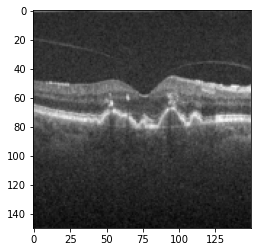

In [6]:
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0), cmap='gray')

#display the first image in the dataset
display_img(*train_dataset[0])

In [7]:
#split training data into training and validation datasets
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = len(train_dataset) // 4
train_size = len(train_dataset) - val_size

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 232
Length of Validation Data : 77


In [8]:
#TODO data augmentation
test_sets = torch.utils.data.ConcatDataset([train_data, val_data])
dl = DataLoader(dataset = test_sets)

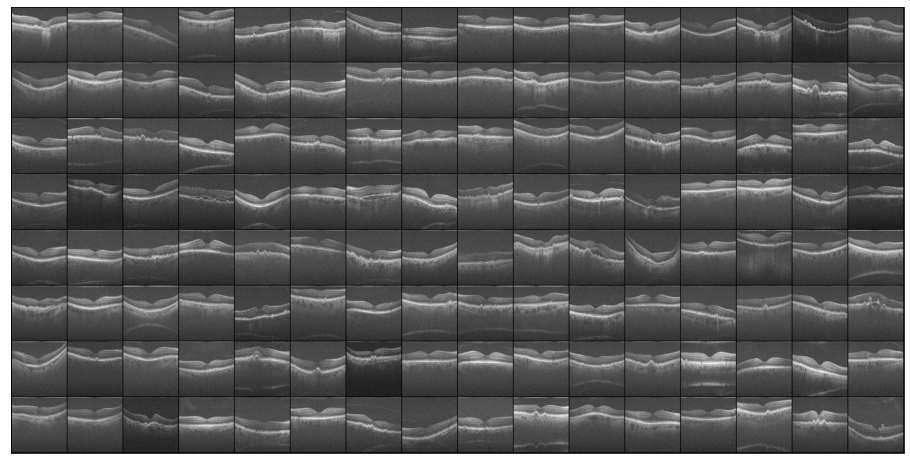

In [9]:
from torchvision.utils import make_grid

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

# CNN Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

#TODO: loss is cross entropy, maybe change it

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [11]:
#classifier for natural scenes from the medium article
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1), #changed 3 to 1 because we use grayscale images
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [12]:
#classifier used in paper [8]
class RetiNetBClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            #TODO more padding to stop losing dimensions?
            nn.Conv2d(1, 16, kernel_size = 5, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32 ,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            
            nn.Flatten(),
            
            nn.Linear(87616,128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [35]:
from sklearn.metrics import confusion_matrix

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad()
def labels_out(model, val_loader):
    model.eval()
    labels_out = []
    for batch in val_loader:
        images, labels = batch
        out = model(images)
        labels_out.append((labels, out))

    return labels_out

def y_pred(model, val_loader):
    model.eval()
    y_pred = []
    for batch in val_loader:
        images, labels = batch 
        out = model(images)                    # Generate predictions
        _, preds = torch.max(out, dim=1)
        y_pred.append(preds)
    return y_pred

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

# Training and testing the model with our dataset

In [ ]:
#fitting the model on training data and record the result after each epoch
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.001#fitting the model on training data and record the result after each epoch
model = RetiNetBClassification()

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    plt.show()
    
plot_accuracies(history)

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, label = 'Training Loss')
    plt.plot(val_losses, label = 'Validation Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Loss vs. No. of epochs');
    plt.show()

plot_losses(history)

In [ ]:
"""#save model if needed
PATH = './model_retiNetB.pth'
torch.save(model.state_dict(), PATH)
"""

In [14]:
#reload model if needed
PATH = './model_retiNetB.pth'
model = RetiNetBClassification()
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
test_dl = DataLoader(test_dataset)
result = evaluate(model, test_dl)

print('Test Dataset: Loss = %s and Accuracy = %s' % (str(result['val_loss']), str(result['val_acc'])))

In [ ]:
# Testing on the OCTID dataset
test_OCTID_data_dir = "../data/OCTID"
test_OCTID_dataset = ImageFolder(test_OCTID_data_dir,transform = transform_for_dataset)
test_OCTID_dl = DataLoader(test_OCTID_dataset)
result_OCTID = evaluate(model, test_OCTID_dl)

print('OCTID Test Dataset: Loss = %s and Accuracy = %s' % (str(result_OCTID['val_loss']), str(result_OCTID['val_acc'])))

# TP, TN, AUC...

In [82]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

def print_confusion_mat(labels, y_preds):
    unpacked_y_preds = []
    unpacked_labels = []
    for i in range(len(labels)):
        unpacked_y_preds.append(y_preds[i].item())
        unpacked_labels.append(labels[i].item())
    cf_matrix=confusion_matrix(unpacked_labels, unpacked_y_preds)
    print(cf_matrix)
    plt.figure(figsize=(5,5))
    sns.heatmap(cf_matrix, annot=[['True AMD\n'+str(cf_matrix[0,0]) , 'False Healthy\n'+str(cf_matrix[0,1])], ['False AMD\n'+str(cf_matrix[1,0]), 'True Healthy\n'+str(cf_matrix[1,1])]], fmt='', cmap='Blues')
    plt.title("Confusion matrix test")
    plt.xlabel("predicted")
    plt.ylabel("actually")
    plt.show()

def print_rates(labels, y_preds):
    unpacked_y_preds = []
    unpacked_labels = []
    for i in range(len(labels)):
        unpacked_y_preds.append(y_preds[i].item())
        unpacked_labels.append(labels[i].item())
    cf_matrix=confusion_matrix(unpacked_labels, unpacked_y_preds)
    print(cf_matrix)
    tp, fn, fp, tn = cf_matrix[0,0], cf_matrix[0,1], cf_matrix[1,0], cf_matrix[1,1]
    print("TPR = %s / TNR = %s" % (str(tp/(fn+tp)), str(fn/(fn+tp))))


[[44  6]
 [ 5 20]]


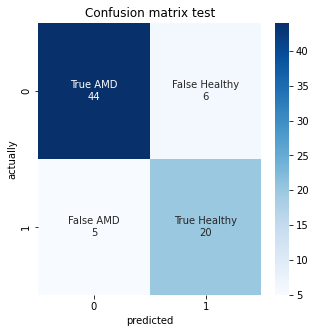

[[44  6]
 [ 5 20]]
TPR = 0.88 / TNR = 0.12


In [83]:
y_preds_test = y_pred(model, test_dl)
labels_test = []
for batch in test_dl:
    _, label = batch
    labels_test.append(label)
print_confusion_mat(labels_test, y_preds_test)
print_rates(labels_test, y_preds_test)

In [79]:
44/(44+6)

0.88

[[ 48   7]
 [156  50]]


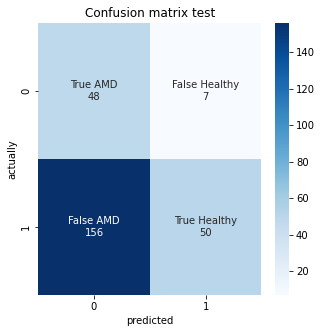

[[ 48   7]
 [156  50]]
TPR = 0.8727272727272727 / TNR = 0.12727272727272726


In [84]:
y_preds_OCTID = y_pred(model, test_OCTID_dl)
labels_OCTID = []
for batch in test_OCTID_dl:
    _, label = batch
    labels_OCTID.append(label)
print_confusion_mat(labels_OCTID, y_preds_OCTID)
print_rates(labels_OCTID, y_preds_OCTID)

# Visualizing the trained filters of the model

In [ ]:
#from course INF573
import math
import random
import numpy as np

def t2im(x):
    """Rearrange the N x K x H x W to have shape (NK) x 1 x H x W.

    Arguments:
        x {torch.Tensor} -- A N x K x H x W tensor.

    Returns:
        torch.Tensor -- A (NK) x 1 x H x W tensor.
    """
    return x.reshape(-1, *x.shape[2:])[:,None,:,:]

def imsc(im, *args, quiet=False, **kwargs):
    """Rescale and plot an image represented as a PyTorch tensor.

     The function scales the input tensor im to the [0 ,1] range.

    Arguments:
        im {torch.Tensor} -- A 3 x H x W or 1 x H x W tensor.

    Keyword Arguments:
        quiet {bool} -- Do not plot. (default: {False})

    Returns:
        torch.Tensor -- The rescaled image tensor.
    """
    handle = None
    with torch.no_grad():
        im = im - im.min() # make a copy
        im.mul_(1/im.max())
        if not quiet:
            bitmap = im.expand(3, *im.shape[1:]).permute(1,2,0).numpy()
            handle = plt.imshow(bitmap, *args, **kwargs)
            ax = plt.gca()
            ax.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
    return im, handle


def imarraysc(tiles, spacing=0, quiet=False):
    """Plot the PyTorch tensor `tiles` with dimesion N x C x H x W as a C x (MH) x (NW) mosaic.

    The range of each image is individually scaled to the range [0, 1].

    Arguments:
        tiles {[type]} -- [description]

    Keyword Arguments:
        spacing {int} -- Thickness of the border (infilled with zeros) around each tile (default: {0})
        quiet {bool} -- Do not plot the mosaic. (default: {False})

    Returns:
        torch.Tensor -- The mosaic as a PyTorch tensor.
    """
    handle = None
    num = tiles.shape[0]
    num_cols = math.ceil(math.sqrt(num))
    num_rows = (num + num_cols - 1) // num_cols
    c = tiles.shape[1]
    h = tiles.shape[2]
    w = tiles.shape[3]
    mosaic = torch.zeros(c,
      h*num_rows + spacing*(num_rows-1),
      w*num_cols + spacing*(num_cols-1))
    for t in range(num):
        u = t % num_cols
        v = t // num_cols
        tile = tiles[t]
        mosaic[0:c,
          v*(h+spacing) : v*(h+spacing)+h,
          u*(w+spacing) : u*(w+spacing)+w] = imsc(tiles[t], quiet=True)[0]
    return imsc(mosaic, quiet=quiet)

In [ ]:
# Visualize the filters in the first layer of the model
plt.figure(1, figsize=(12,12))
visualization = imarraysc(model.network[0].weight, spacing=1)

Label : amd


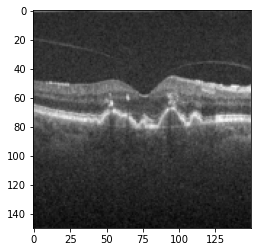

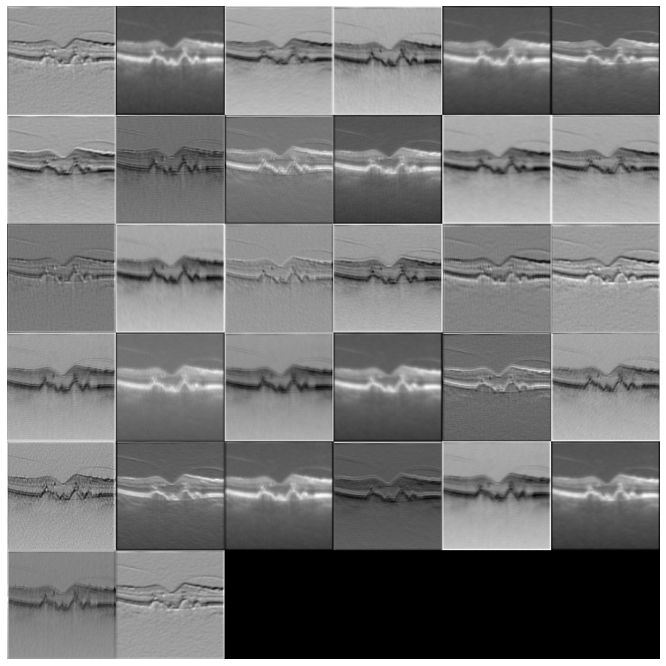

In [39]:
img, label = train_dataset[0]
display_img(img,label)
img = img.reshape(1,1,150,150)
"""transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),transforms.Resize((150,150)),transforms.ToTensor()])"""
output_first_layer = F.conv2d(img, model.network[0].weight, padding = 1)
output_second_layer = F.conv2d(output_first_layer, model.network[2].weight, padding = 2)
plt.figure(figsize=(12,12))
#visualization = imarraysc(t2im(output_first_layer))
visualization2 = imarraysc(t2im(output_second_layer))